<a href="https://colab.research.google.com/github/imostafizur/NASA_Space_App_2023/blob/master/NASA_Space_App_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

os.environ['KAGGLE_USERNAME'] = "imostafizur" # username from the json file
os.environ['KAGGLE_KEY'] = "7d0d1dbed1b70b444fde448c4f29af3d" # key from the json file

In [2]:
!kaggle datasets download -d arashnic/soalr-wind

 99% 274M/276M [00:03<00:00, 85.0MB/s]
100% 276M/276M [00:03<00:00, 74.9MB/s]


In [3]:
!unzip /content/soalr-wind.zip

Archive:  /content/soalr-wind.zip
  inflating: labels.csv              
  inflating: satellite_pos.csv       
  inflating: solar_wind.csv          
  inflating: sunspots.csv            


In [4]:
import pandas as pd

In [5]:
solar_wind = pd.read_csv("solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

dst = pd.read_csv("labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

sunspots = pd.read_csv("sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

In [6]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(2020)
set_seed(2021)

In [7]:
from sklearn.preprocessing import StandardScaler

# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)


def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler


In [8]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()

(139872, 15)


bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 0 days 00:00:00  0.499705  2.443614         -0.375267   
        0 days 01:00:00  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [9]:
assert (features.isna().sum() == 0).all()

In [10]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    y = dst.copy()
    y["t1"] = y.groupby("period").dst.shift(-1)
    y.columns = YCOLS
    return y


labels = process_labels(dst)
labels.head()

t0    t1
period  timedelta                
train_a 0 days 00:00:00  -7 -10.0
        0 days 01:00:00 -10 -10.0
        0 days 02:00:00 -10  -6.0
        0 days 03:00:00  -6  -2.0
        0 days 04:00:00  -2   3.0

In [11]:
data = labels.join(features)
data.head()

t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                         
train_a 0 days 00:00:00  -7 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10 -10.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00 -10  -6.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -6  -2.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  -2   3.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [12]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = data.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=3_000)

In [13]:
import tensorflow as tf
from keras import preprocessing


data_config = {
    "timesteps": 32,
    "batch_size": 32,
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset


train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")


Number of train batches: 3804
Number of val batches: 276


## ANN

In [14]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [15]:
# Define the ANN model
ann_model = Sequential()
ann_model.add(Dense(64, input_shape=(len(XCOLS),), activation='relu'))  # Input layer with 64 units and ReLU activation
ann_model.add(Dropout(0.2))  # Dropout layer to reduce overfitting
ann_model.add(Dense(32, activation='relu'))  # Hidden layer with 32 units and ReLU activation
ann_model.add(Dense(len(YCOLS)))  # Output layer with the same number of units as the target variables

In [16]:

# Compile the model
ann_model.compile(loss='mean_squared_error', optimizer='adam')

# Print the model summary
ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1024      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3,170
Trainable params: 3,170
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Train the ANN model
history_ann = ann_model.fit(
    train[XCOLS],  # Training features
    train[YCOLS],  # Training labels
    batch_size=32,  # Batch size
    epochs=20,  # Number of epochs
    verbose=1,  # Set to 1 for training progress
    validation_data=(val[XCOLS], val[YCOLS]),  # Validation data
    shuffle=True,  # Shuffle training data
)

# Evaluate the model on the test data
test_loss = ann_model.evaluate(test[XCOLS], test[YCOLS])
print(f"Test Loss: {test_loss:.2f}")


Epoch 1/20
3809/3809 [==============================] - 9s 2ms/step - loss: 229.2628 - val_loss: nan
Epoch 2/20
3809/3809 [==============================] - 12s 3ms/step - loss: 211.0307 - val_loss: nan
Epoch 3/20
3809/3809 [==============================] - 8s 2ms/step - loss: 207.4436 - val_loss: nan
Epoch 4/20
3809/3809 [==============================] - 9s 2ms/step - loss: 206.1861 - val_loss: nan
Epoch 5/20
3809/3809 [==============================] - 8s 2ms/step - loss: 204.1913 - val_loss: nan
Epoch 6/20
3809/3809 [==============================] - 9s 2ms/step - loss: 202.6053 - val_loss: nan
Epoch 7/20
3809/3809 [==============================] - 8s 2ms/step - loss: 201.6006 - val_loss: nan
Epoch 8/20
3809/3809 [==============================] - 9s 2ms/step - loss: 201.3726 - val_loss: nan
Epoch 9/20
3809/3809 [==============================] - 8s 2ms/step - loss: 199.8561 - val_loss: nan
Epoch 10/20
3809/3809 [==============================] - 9s 2ms/step - loss: 198.9465 - va

In [18]:
import matplotlib.pyplot as plt

563/563 [==============================] - 1s 1ms/step


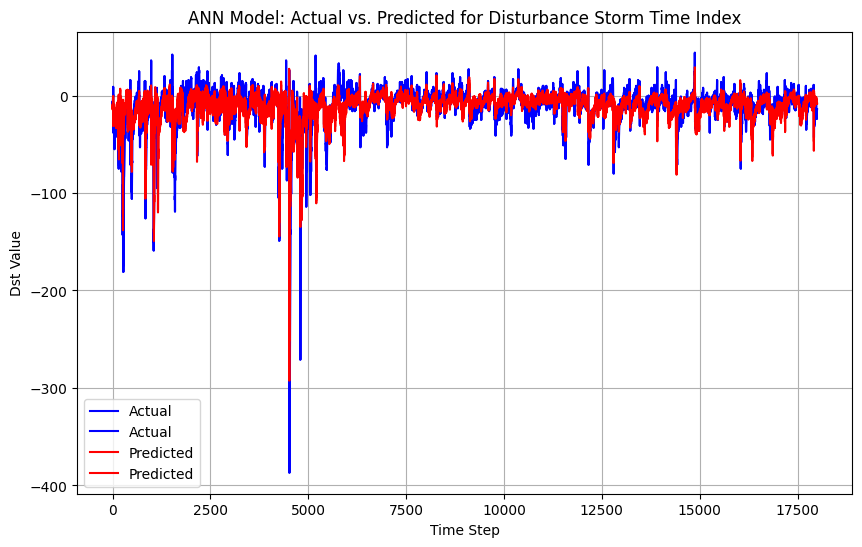

In [19]:
import matplotlib.pyplot as plt

# Make predictions using the ANN model
ann_predictions = ann_model.predict(test[XCOLS])

# Extract the actual values from the test data
actual_values = test[YCOLS].values

# Create a plot to compare actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual', color='blue')
plt.plot(ann_predictions, label='Predicted', color='red')
plt.title('ANN Model: Actual vs. Predicted for Disturbance Storm Time Index')
plt.xlabel('Time Step')
plt.ylabel('Dst Value')
plt.legend()
plt.grid(True)
plt.show()


## CNN

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [21]:
# Preprocess the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[XCOLS])
test_scaled = scaler.transform(test[XCOLS])

# Reshape the data to fit the CNN input format
train_scaled = train_scaled.reshape(train_scaled.shape[0], train_scaled.shape[1], 1)
test_scaled = test_scaled.reshape(test_scaled.shape[0], test_scaled.shape[1], 1)


In [22]:
# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(train_scaled.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(len(YCOLS)))

# Compile the CNN model
cnn_model.compile(loss='mean_squared_error', optimizer='adam')

# Print the model summary
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense_3 (Dense)             (None, 32)                12320     
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 12,642
Trainable params: 12,642
Non-trainable params: 0
__________________________________________________

In [23]:
# Train the CNN model
history_cnn = cnn_model.fit(
    train_scaled, train[YCOLS],
    epochs=20,
    batch_size=32,
    verbose=1,
    validation_data=(test_scaled, test[YCOLS]),
    shuffle=True
)

Epoch 1/20
3809/3809 [==============================] - 15s 4ms/step - loss: 242.5621 - val_loss: nan
Epoch 2/20
3809/3809 [==============================] - 19s 5ms/step - loss: 220.6761 - val_loss: nan
Epoch 3/20
3809/3809 [==============================] - 12s 3ms/step - loss: 216.0565 - val_loss: nan
Epoch 4/20
3809/3809 [==============================] - 10s 3ms/step - loss: 213.6269 - val_loss: nan
Epoch 5/20
3809/3809 [==============================] - 12s 3ms/step - loss: 211.6332 - val_loss: nan
Epoch 6/20
3809/3809 [==============================] - 13s 3ms/step - loss: 210.1192 - val_loss: nan
Epoch 7/20
3809/3809 [==============================] - 11s 3ms/step - loss: 208.6478 - val_loss: nan
Epoch 8/20
3809/3809 [==============================] - 12s 3ms/step - loss: 207.8572 - val_loss: nan
Epoch 9/20
3809/3809 [==============================] - 12s 3ms/step - loss: 207.0605 - val_loss: nan
Epoch 10/20
3809/3809 [==============================] - 11s 3ms/step - loss: 206.

In [24]:
# Evaluate the CNN model on the test data
test_loss = cnn_model.evaluate(test_scaled, test[YCOLS])
print(f"Test Loss: {test_loss:.2f}")

# Make predictions using the CNN model
cnn_predictions = cnn_model.predict(test_scaled)

563/563 [==============================] - 1s 2ms/step - loss: nan
Test Loss: nan
563/563 [==============================] - 1s 1ms/step


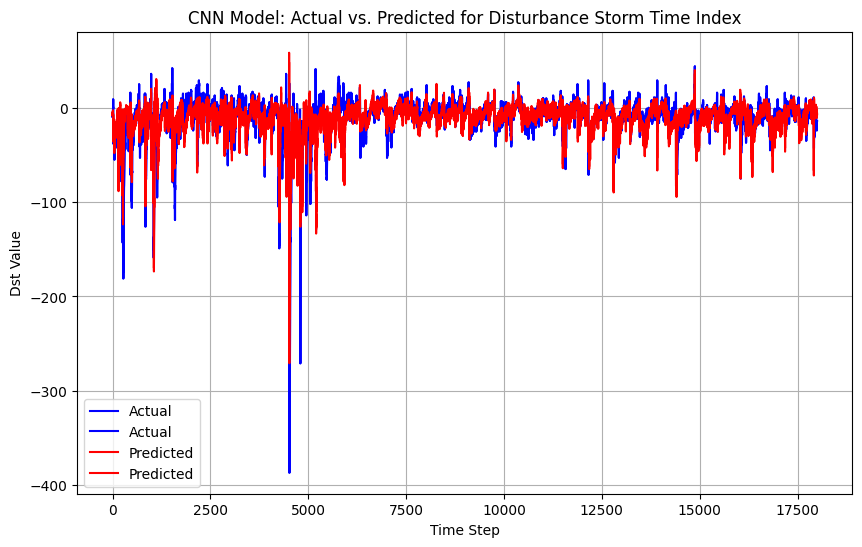

In [25]:
# Create a prediction plot
plt.figure(figsize=(10, 6))
plt.plot(test[YCOLS].values, label='Actual', color='blue')
plt.plot(cnn_predictions, label='Predicted', color='red')
plt.title('CNN Model: Actual vs. Predicted for Disturbance Storm Time Index')
plt.xlabel('Time Step')
plt.ylabel('Dst Value')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Reshape

# Define the RNN model
rnn_model = Sequential()
rnn_model.add(Reshape((1, len(XCOLS)), input_shape=(len(XCOLS),)))  # Reshape input data
rnn_model.add(SimpleRNN(64, activation='relu'))  # Simple RNN layer with 64 units and ReLU activation
rnn_model.add(Dropout(0.2))  # Dropout layer to reduce overfitting
rnn_model.add(Dense(32, activation='relu'))  # Hidden layer with 32 units and ReLU activation
rnn_model.add(Dense(len(YCOLS)))  # Output layer with the same number of units as the target variables

# Compile the RNN model
rnn_model.compile(loss='mean_squared_error', optimizer='adam')

# Print the model summary
rnn_model.summary()

# Train the RNN model
history_rnn = rnn_model.fit(
    train[XCOLS],  # Training features
    train[YCOLS],  # Training labels
    batch_size=32,  # Batch size
    epochs=20,  # Number of epochs
    verbose=1,  # Set to 1 for training progress
    validation_data=(val[XCOLS], val[YCOLS]),  # Validation data
    shuffle=True,  # Shuffle training data
)

# Evaluate the RNN model on the test data
test_loss_rnn = rnn_model.evaluate(test[XCOLS], test[YCOLS])
print(f"Test Loss (RNN): {test_loss_rnn:.2f}")


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 15)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                5120      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 2)                 66        
                                                                 
Total params: 7,266
Trainable params: 7,266
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
3809/3809 [==============================

563/563 [==============================] - 1s 2ms/step


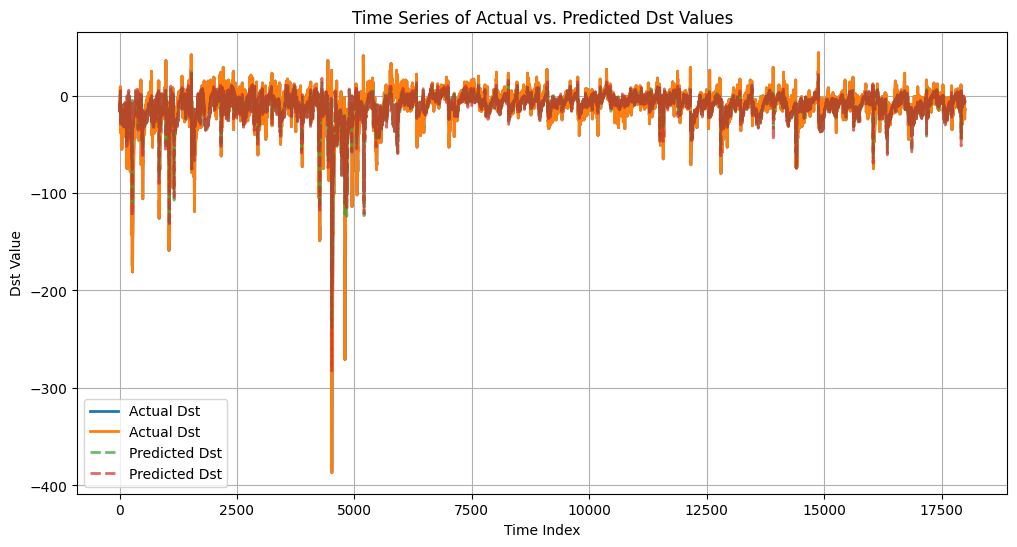

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Get the number of data points in the test data
num_data_points = len(test)

# Generate a time index for the test data (assuming a uniform time interval)
test_time_index = np.arange(num_data_points)  # This creates a simple time index from 0 to num_data_points-1

# Predict Dst values on the test data
predicted_dst = rnn_model.predict(test[XCOLS])

# Assuming you have a variable 'test_actual_dst' containing the actual Dst values for the test data
test_actual_dst = test[YCOLS]

# Create a time series line plot for actual and predicted Dst values
plt.figure(figsize=(12, 6))
plt.plot(test_time_index, test_actual_dst, label='Actual Dst', linewidth=2)
plt.plot(test_time_index, predicted_dst, label='Predicted Dst', linestyle='dashed', alpha=0.7, linewidth=2)
plt.xlabel('Time Index')
plt.ylabel('Dst Value')
plt.title('Time Series of Actual vs. Predicted Dst Values')
plt.legend()
plt.grid(True)
plt.show()


## LSTM

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the LSTM model
model = keras.Sequential([
    layers.LSTM(64, input_shape=(data_config["timesteps"], len(XCOLS)), return_sequences=True),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(len(YCOLS))
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model architecture
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 64)            20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 53,634
Trainable params: 53,634
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
3804/3804 [==============================] - 213s 54ms/step - loss: 313.8396 - mae: 11.2093 - val_loss: 482.9021 - val_mae: 11.9532
Epoch 2/10
3804/3804 [==============================] - 200s 53ms/step - loss: 223.6169 - mae: 9.2262 - val_loss: 412.9481 - val_mae: 10.5038
Epoch 3/10
3804/3804 [==============================] - 203s 53ms/step - loss: 192.3876 - mae: 8.7004 - val_loss: 378.8800 - val_mae: 10.0538
Epoch 4/10
3804/3804 [==============================] - 202s 53ms/step - loss: 166.3500 - mae: 8.2653 - val_loss: 358.0273 - val_mae: 9.8149
Epoch 5/10
3804/3804 [==============================] - 208s 55ms/step - loss: 151.6046 - mae: 8.1068 - val_loss: 327.8854 - val_mae: 9.5307
Epoch 6/10
3804/3804 [==============================] - 201s 53ms/step - loss: 139.8730 - mae: 7.9497 - val_loss: 306.8898 - val_mae: 9.5047
Epoch 7/10
3804/3804 [==============================] - 198s 52ms/step - loss: 131.4414 - mae: 7.7864 - val_loss: 286.6691 - val_mae: 9.3025
Epoch 8/1

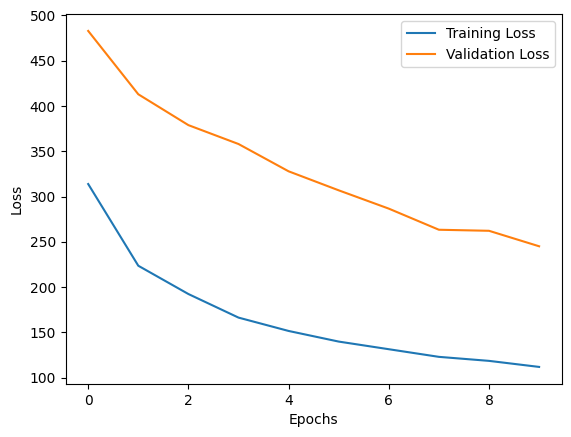

In [29]:
# Training the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # Adjust the number of epochs as needed
)

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


1/1 [==============================] - 0s 29ms/step


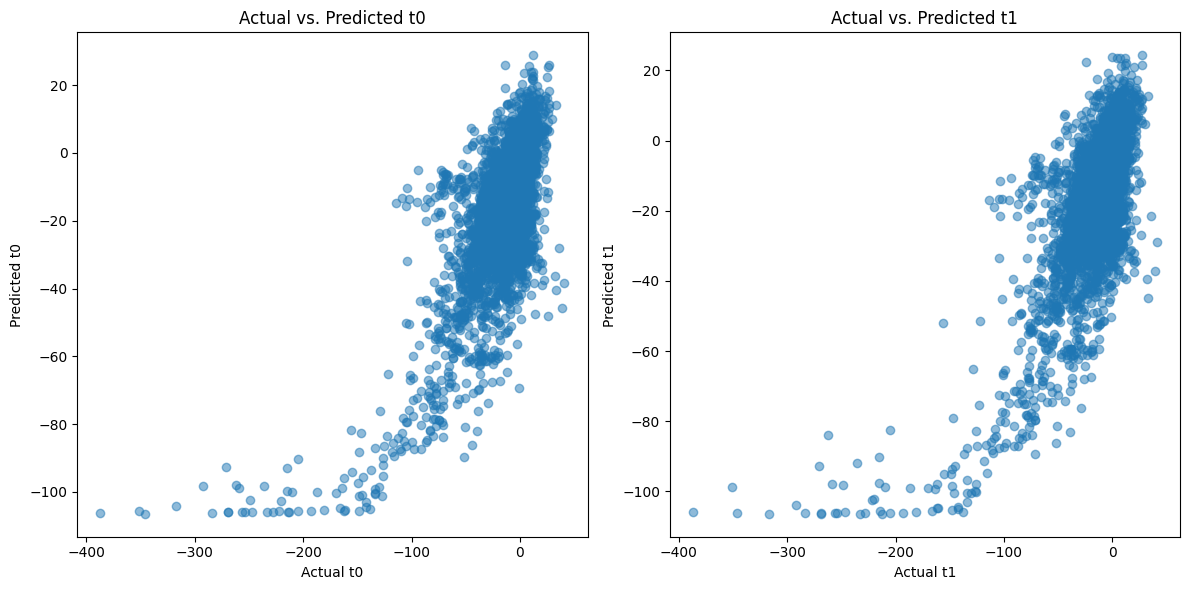

In [30]:
import matplotlib.pyplot as plt

# Initialize empty arrays for predictions and actual values
y_test_actual = []
y_test_predicted = []

# Iterate through val_ds and make predictions
for x, y in val_ds:
    # Make predictions for the current batch
    y_pred_batch = model.predict(x)
    y_test_predicted.append(y_pred_batch)

    # Append the actual values
    y_test_actual.append(y)

# Convert the lists to NumPy arrays
y_test_actual = np.concatenate(y_test_actual)
y_test_predicted = np.concatenate(y_test_predicted)

# Assuming you have two target variables (t0 and t1)
target_index_t0 = YCOLS.index("t0")
target_index_t1 = YCOLS.index("t1")

# Plot actual vs. predicted for t0
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test_actual[:, target_index_t0], y_test_predicted[:, target_index_t0], alpha=0.5)
plt.xlabel("Actual t0")
plt.ylabel("Predicted t0")
plt.title("Actual vs. Predicted t0")

# Plot actual vs. predicted for t1
plt.subplot(1, 2, 2)
plt.scatter(y_test_actual[:, target_index_t1], y_test_predicted[:, target_index_t1], alpha=0.5)
plt.xlabel("Actual t1")
plt.ylabel("Predicted t1")
plt.title("Actual vs. Predicted t1")

plt.tight_layout()
plt.show()
